In [55]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import sys
from pathlib import Path

from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Set up paths
NOTEBOOK_DIR = Path.cwd()
SRC_DIR = NOTEBOOK_DIR.parent / "src"
sys.path.append(str(SRC_DIR))

# Import the shared paths
from paths import (
    CSV_DIR,
    DATAFRAMES_DIR,
    HOURLY_GREYSCALE_IMAGES_DIR,
    HOURLY_TENSORS_SEASONALITY
)

In [2]:
def load_tensors_to_array(tensor_dir):
    # Load all tensors into a single array
    #tensor_dir = "tensor_data_from_greyscaleTeide - OT"
    tensor_files = sorted([f for f in os.listdir(tensor_dir) if f.endswith(".npy")])
    
    # Load all tensors into a list
    all_tensors = [np.load(os.path.join(tensor_dir, f)) for f in tensor_files]
    X = np.array(all_tensors)
    
    print("Shape of X:", X.shape)  # Should be (823, 79, 168, 4)

    return X

In [3]:
X_teide = load_tensors_to_array(NOTEBOOK_DIR.parent / HOURLY_TENSORS_SEASONALITY / "OT")

Shape of X: (823, 79, 168, 3)


In [4]:
X_roque = load_tensors_to_array(NOTEBOOK_DIR.parent / HOURLY_TENSORS_SEASONALITY / "ORM")

Shape of X: (1350, 79, 168, 3)


In [5]:
#NO need to split data , since I am doing predict only to extract features

#### In the next cell I am using EfficientNetB1 but loading the weights from advprop instead of imagenet which is the default value.
#### EfficientNetB1 arquitecture because is still a lightweight net but good enough for this type of data.
#### why advprop weights? It expects inputs normalized to [0, 255] (raw pixel range) — no scaling to [-1, 1] as with standard ImageNet. 

In [6]:
def extract_features_EfficientNet(X_site):
    weights_path = NOTEBOOK_DIR.parent / "adv.prop.notop-b1.h5"

    # Create the model with weights set to None
    base_model = EfficientNetB1(
        include_top=False,
        input_shape=(79, 168, 3),
        pooling='avg',
        weights=None
    )
    
    # Load the local weights
    base_model.load_weights(weights_path)
    
    # Freeze the layers of EfficientNetB0 (no fine-tuning here)
    base_model.trainable = False
    
    # Create input tensor matching your data (3 channels: heatmap, season_sin, season_cos)
    input_tensor = Input(shape=(79, 168, 3))
    
    # Pass the input through ResNet
    features = base_model(input_tensor)
    
    # Wrap into a feature extractor model
    feature_extractor = Model(inputs=input_tensor, outputs=features)
    
    # Extract features
    features = feature_extractor.predict(X_site, verbose=1)
    
    return features

In [7]:
features_teide = extract_features_EfficientNet(X_teide)
features_roque = extract_features_EfficientNet(X_roque)

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 519ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

def calculate_plot_inertia_and_silhouette(features):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    axes = axes.flatten()  # So we can index them from 0 to 11

    inertias = [] #Saving the inertias values for a test of fitting KMeans with a range of clusters from 2 to 20
    silhouette_coef = [] # Same but for silhouette_coef
    
    for k in range(2,20):
        kmeans = KMeans(k, random_state=42) #every step of the loop , set the KMeans algorithm with a new K, 2,3,4,5,....
        kmeans.fit(features)
        #saving the inertias value to plot them 
        inertias.append(kmeans.inertia_)
    
        #now calculating the shilouette scores to plot them also
        score = silhouette_score(features, kmeans.labels_)
        silhouette_coef.append(score)

    ax = axes[0]
    #plot inertias to look for elbow point     
    ax.plot(range(2, 20), inertias, 'bx-')
    ax.set_xlabel('Ks')  # Corrected from `ax.xlabel`
    ax.set_xticks(np.arange(2, 21, 1))  # Corrected from `ax.xticks`
    ax.set_ylabel('Inertia')  # Corrected from `ax.ylabel`
    ax.set_title('Inertias looking for elbow point')  # Corrected from `ax.title`
    ax.grid(True)

    ax = axes[1]
    #And now silhouette score visualization
    ax.plot(range(2, 20), silhouette_coef, 'bx-')
    ax.set_xlabel('Ks')  # Corrected from `ax.xlabel`
    ax.set_xticks(np.arange(2, 21, 1))  # Corrected from `ax.xticks`
    ax.set_ylabel('Silhouette coefficient')  # Corrected from `ax.ylabel`
    ax.set_title('Silhouette scores')  # Corrected from `ax.title`
    ax.grid(True)

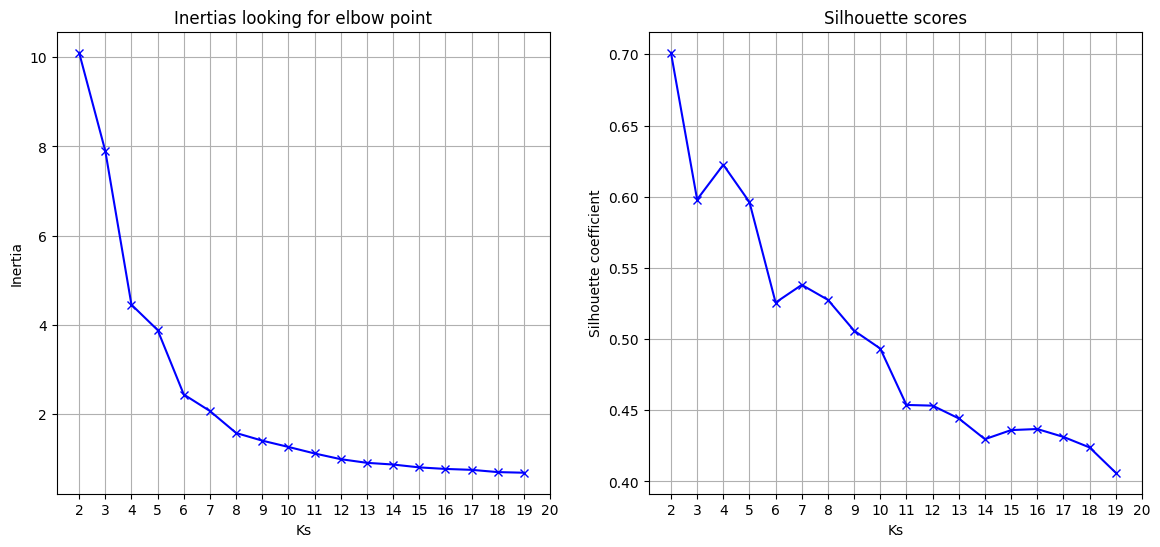

In [9]:
calculate_plot_inertia_and_silhouette(features_teide)

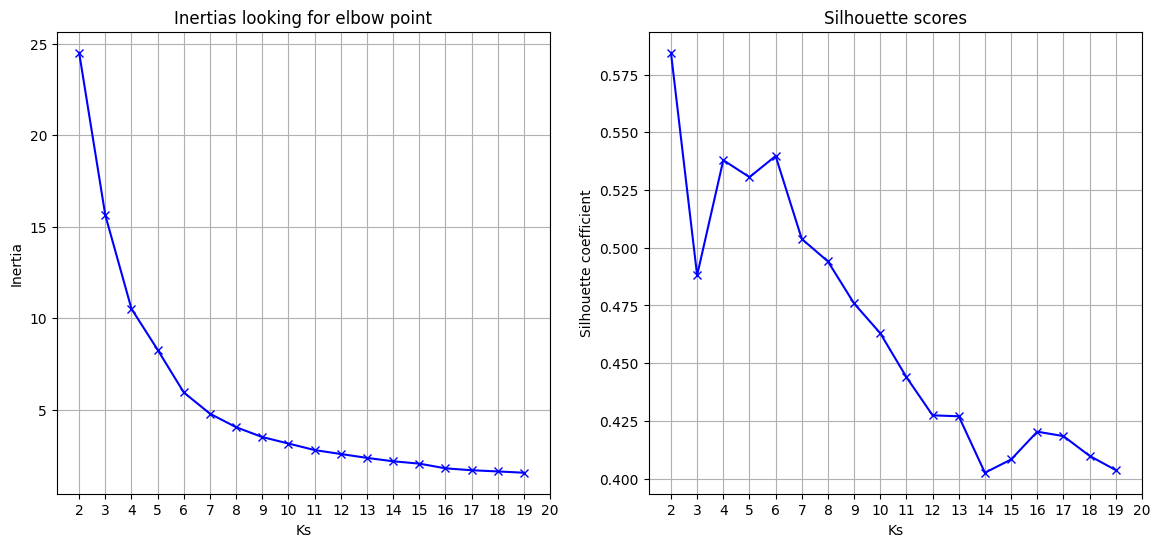

In [10]:
calculate_plot_inertia_and_silhouette(features_roque)

In [11]:
from sklearn.cluster import KMeans

def apply_kmeans(features, n_clusters):
    # Perform clustering on the extracted features using KMeans
    num_clusters = n_clusters  # You can adjust this to try different numbers based on the previous graphics
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(features)

    return cluster_labels
# Now I can use the cluster_labels for clustering analysis or visualizations

In [12]:
from sklearn.decomposition import PCA
def apply_PCA(components,features):
    # Perform PCA to reduce the dimensionality to N dimensions
    pca = PCA(n_components=components)
    pca_result = pca.fit_transform(features)

    return pca, pca_result

In [13]:
#Based on features info, let's apply a PCA to reduce dimensinality
#and see what percentage is explained by each PC (Principal Component)
pca_teide, pca_results_teide = apply_PCA(2, features_teide)
pca_roque, pca_results_roque = apply_PCA(2, features_roque)

In [14]:
print(pca_teide.explained_variance_ratio_)
print(pca_roque.explained_variance_ratio_)

[0.92561585 0.06132254]
[0.8847264  0.10041235]


In [15]:
#Now with the features info , let's do a clustering using KMeans
#We can do several tries with different number of clusters
desired_clusters = 4
clusters_teide = apply_kmeans(features_teide,desired_clusters)
clusters_roque = apply_kmeans(features_roque,desired_clusters)

In [16]:
#Plot the clusters based on all this info.
def plot_clusters(pca_results, clusters, site):
    # Plot the 2D projection of the PCA result
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_results[:, 0], pca_results[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(label='Cluster Label')
    plt.title(f'PCA - Clusters Visualization {site}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

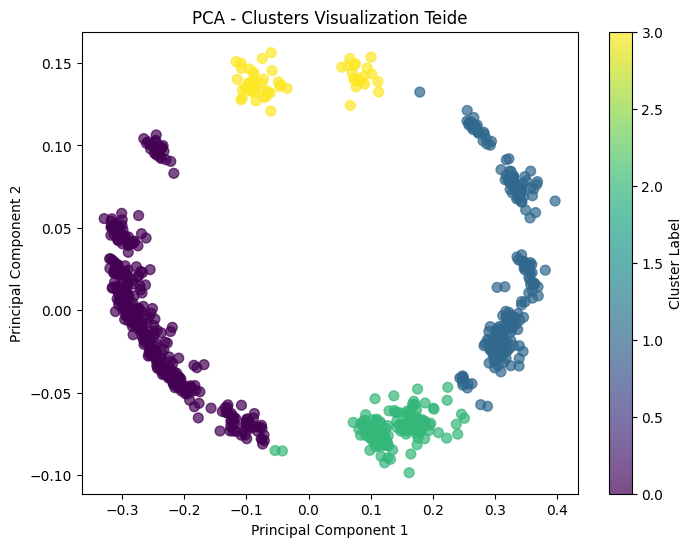

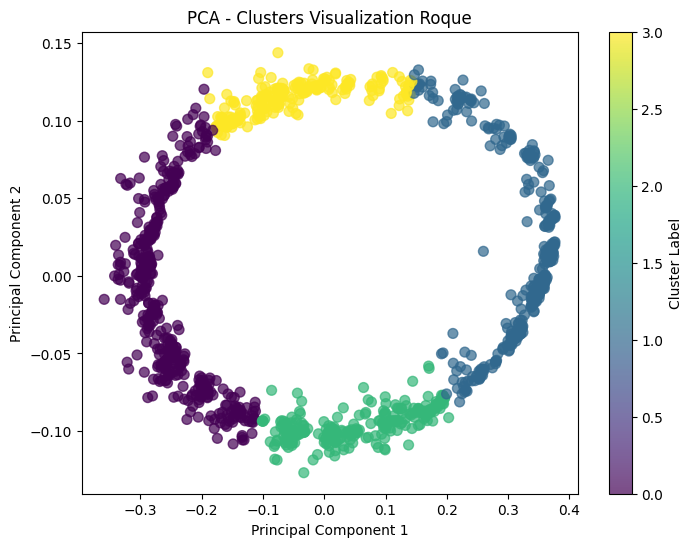

In [17]:
plot_clusters(pca_results_teide,clusters_teide,'Teide')
plot_clusters(pca_results_roque,clusters_roque,'Roque')

### Evaluate clusters quality with some metrics. 
🟢 Silhouette Index (Coefficient)
Measures:
How similar an object is to its own cluster compared to other clusters.

Range:  
-1 to +1. 
Summary:  
+1: Points are well-clustered, with distinct boundaries between clusters.  
0: Points are on the boundary between clusters, suggesting that they might belong to either cluster.  
-1: Points are likely misclassified into the wrong cluster.  

Interpretation: Higher silhouette values indicate better-defined clusters.  

🔵 Davies-Bouldin Score. 
Measures:  
Average "similarity" (or ratio of within-cluster scatter to between-cluster separation) for each cluster with its most similar one.  

Range:  
0 to ∞. 

Interpretation : Lower values are better: they indicate more compact and well-separated clusters

In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
def calculate_silhouette_bouldin_scores(features,cluster_labels):
    # Calculate the silhouette score
    score = silhouette_score(features, cluster_labels)
    print(f'Silhouette Score: {score}')

    # Calculate the Davies-Bouldin index
    db_score = davies_bouldin_score(features, cluster_labels)
    print(f'Davies-Bouldin Index: {db_score}')

In [20]:
print("Teide")
calculate_silhouette_bouldin_scores(features_teide,clusters_teide)

Teide
Silhouette Score: 0.622438907623291
Davies-Bouldin Index: 0.5626999138272013


In [21]:
print("Roque")
calculate_silhouette_bouldin_scores(features_roque,clusters_roque)

Roque
Silhouette Score: 0.540564775466919
Davies-Bouldin Index: 0.6637669887650253


### Lets add clusters info to the main DFs

In [51]:
df_teide = pd.read_parquet(DATAFRAMES_DIR / "df_teide_full_Info.parquet")
df_roque = pd.read_parquet(DATAFRAMES_DIR / "df_roque_full_Info.parquet")

In [59]:
#I am using the original file names .csv file , and cluster labels for merging purposes with the original dataframe
#with all the info about profiles , which are measurements-turbulence sets
# Load tensor filenames (used for X_train)
tensor_names_teide = pd.read_csv(CSV_DIR /'tensors_names_teide.csv', header=0, names=['date_hour'])
tensor_names_teide['site'] = 'Teide'  # optional but useful
tensor_names_teide['cluster'] = clusters_teide  # assuming same order as X_train

# Repeat for Roque
tensor_names_roque = pd.read_csv(CSV_DIR /'tensors_names_roque.csv', header=0, names=['date_hour'])
tensor_names_roque['site'] = 'Roque'
tensor_names_roque['cluster'] = clusters_roque

In [61]:
tensor_names_teide['cluster'].value_counts() # => 823 in total

cluster
0    385
1    232
2    149
3     57
Name: count, dtype: int64

In [65]:
tensor_names_roque['cluster'].value_counts()# => 1350 in total 

cluster
0    483
1    380
2    260
3    227
Name: count, dtype: int64

#### This ensures that every profile_id in df_teide and df_roque gets the appropriate cluster label corresponding to the tensor to which it belongs. Which is controlled by its name as date_hour format.

In [67]:
df_teide['date_hour'] = df_teide['timestamp_begin'].dt.strftime('%Y-%m-%d_hour_%H')
df_roque['date_hour'] = df_roque['timestamp_begin'].dt.strftime('%Y-%m-%d_hour_%H')

In [70]:
#Adding cluster info to main DFs
df_teide = df_teide.merge(tensor_names_teide[['date_hour', 'cluster']], on='date_hour', how='left')
df_roque = df_roque.merge(tensor_names_roque[['date_hour', 'cluster']], on='date_hour', how='left')

In [72]:
#Save both DataFrames as .parquet files, after finishing all process
df_teide.to_parquet(DATAFRAMES_DIR / "df_teide_with_clusters.parquet", index=False, engine='pyarrow')
df_roque.to_parquet(DATAFRAMES_DIR / "df_roque_with_clusters.parquet", index=False, engine='pyarrow')